In [57]:
# %%
# %   COURSE: Neural signal processing and analysis: Zero to hero
# %  SECTION: Synchronization problem set
# %  TEACHER: Mike X Cohen, sincxpress.com
# %

import sys
sys.path.insert(1, '../')
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import cmath
from scipy.io import loadmat
from scipy.signal import firwin, filtfilt, hilbert
from numpy.fft import fft, ifft
import random
import matplotlib as mpl
from attributedict.collections import AttributeDict



mpl.rcParams['figure.figsize'] = (12, 6) 
pi = np.pi

In [75]:
laminar = loadmat("../v1_laminar.mat")
(nchans, npnts, ntrials) = laminar['csd'].shape
srate = laminar['srate']
data = laminar['csd']
timevec = laminar['timevec'].T

# specify frequencies
frex = [8,55]
nCycles = [7,14]

# parameters for complex Morlet wavelets
wavtime = np.arange(-1,1-1/srate, 1/srate)
half_wav = (len(wavtime)-1)//2

# FFT parameters
nWave = len(wavtime)
nData = npnts*ntrials
nConv = nData + nWave - 1

# create wavelets
cmwX = np.zeros((len(frex), nConv), dtype=complex)
for fi in range(len(frex)):
    s = nCycles[fi] / (2*pi*frex[fi])
    cmw = np.exp(1j*2*pi*frex[fi]*wavtime) * np.exp((-wavtime**2) / (2*s**2))
    tempX = fft(cmw, nConv)
    cmwX[fi, :] = tempX / np.max(tempX)

In [77]:
# %% run convolution to extract phase values (don't need power)
# % store the phase angle time series in a 
# %    channels X frequency X time X trials matrix

allphases = np.zeros((nchans, len(frex), npnts, ntrials))

# % spectrum of all channels using the fft matrix input 
# % (check the matrix sizes and FFT inputs!)
dataX = fft(np.reshape(data, (nchans,npnts*ntrials), order='F'), nConv, axis=1);

for fi in range(len(frex)):
    for chani in range(nchans):
        
    
    #     % run convolution
        as_ = ifft(dataX[chani, :]*cmwX[fi])
        as_ = as_[half_wav:-half_wav]
        as_ = np.reshape(as_, (npnts, ntrials), order='F')

    #     % phase values from all trials
        allphases[chani,fi,:,:] = np.angle( as_ );


In [78]:
# %% now compute connectivity
# % Compute connectivity separately in two time windows:
# %   .1 to .4, and .6 to .9 seconds.
# % To do this, first compute synchronization over trials, then average the
# %    synchronization values within those time windows.

def tToInd(t):
    return np.argmin(abs(timevec - t))

# % define time windows
tidx1 =[tToInd(.1),  tToInd(.4)]
tidx2 = [tToInd(.6),  tToInd(.9)]


# % initialize a channels X channels X frequency X time period matrix
connmat = np.zeros( (nchans,nchans,len(frex),2));

# % in a double for-loop, compute phase synchronization between each pair
# % inside the for-loop 
for chani in range(nchans):
    for chanj  in range(nchans):
        
        phase1 = allphases[chani, :,:,:] 
        phase2 = allphases[chanj, :, :, :]
#         % compute eulerized phase angle differences
        phasediffs = np.exp(1j*(phase1 - phase2))
        
#         % compute phase synchronization (ISPC) for all time points
        ispc = abs(np.mean(phasediffs, axis=2)) #mean over trials # frex x time
        
#         % get data averaged from the two time windows
        connmat[chani,chanj,:,0] = np.mean(ispc[:, tidx1[0]:tidx1[1]+1], axis=1)
        connmat[chani,chanj,:,1] = np.mean(ispc[:, tidx2[0]:tidx2[1]+1], axis=1)


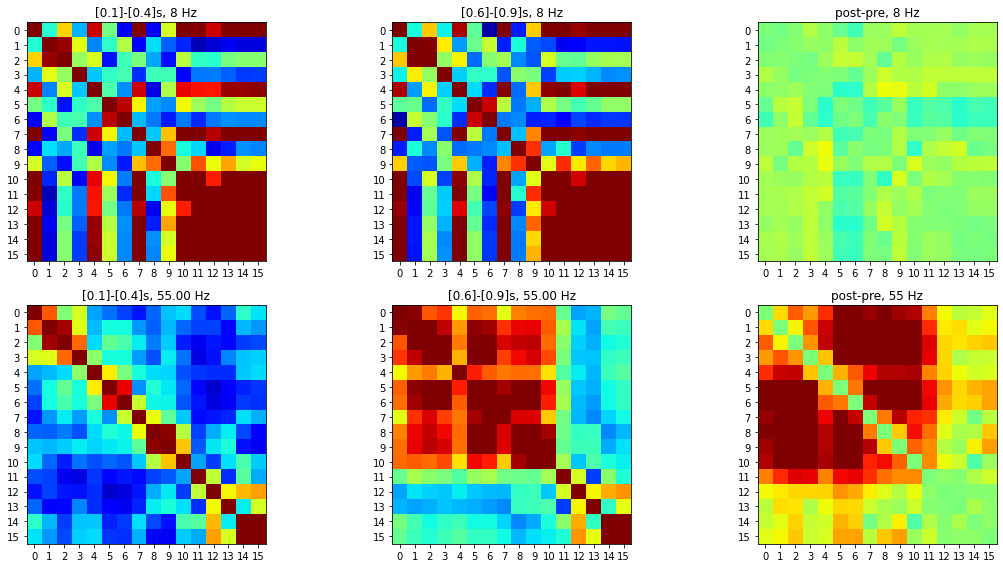

In [79]:
# %% Make all-to-all connectivity plots
# % In one figure, make six chan-by-chan matrices for 8 and 55 hz (upper and lower plots)
# %   from averaged connectivity between .1-.4 s (left) and .6-.9 s (middle). 
# % The right-most plot should show the difference of late-early connectivity.
# % Use the same colorscaling for all 'raw' plots, 
# %   and a different colorscaling for the difference plots.

# define color limits
clim  = [0, 0.8]
climD = [-0.4, 0.4]

fig, ax = plt.subplots(2, 3, figsize=(16, 8))

# First row
img1 = ax[0, 0].imshow(np.squeeze(connmat[:,:,0,0]), cmap='jet')
img1.set_clim(clim)
ax[0, 0].set_xticks(range(nchans))
ax[0, 0].set_yticks(range(nchans))
ax[0, 0].set_title(f'{np.round_(timevec[tidx1[0]], 1)}-{np.round_(timevec[tidx1[1]], 1)}s, {frex[0]} Hz')

img2 = ax[0, 1].imshow(np.squeeze(connmat[:,:,0,1]), cmap='jet')
img2.set_clim(clim)
ax[0, 1].set_xticks(range(nchans))
ax[0, 1].set_yticks(range(nchans))
ax[0, 1].set_title(f'{np.round_(timevec[tidx2[0]], 1)}-{np.round_(timevec[tidx2[1]], 1)}s, {frex[0]} Hz')

img3 = ax[0, 2].imshow(np.squeeze(connmat[:,:,0,1] - connmat[:,:,0,0]), cmap='jet')
img3.set_clim(climD)
ax[0, 2].set_xticks(range(nchans))
ax[0, 2].set_yticks(range(nchans))
ax[0, 2].set_title(f'post-pre, {frex[0]} Hz')

# Second row
img4 = ax[1, 0].imshow(np.squeeze(connmat[:,:,1,0]), cmap='jet')
img4.set_clim(clim)
ax[1, 0].set_xticks(range(nchans))
ax[1, 0].set_yticks(range(nchans))
ax[1, 0].set_title(f'{np.round_(timevec[tidx1[0]], 1)}-{np.round_(timevec[tidx1[1]], 1)}s, {frex[1]:.2f} Hz')

img5 = ax[1, 1].imshow(np.squeeze(connmat[:,:,1,1]), cmap='jet')
img5.set_clim(clim)
ax[1, 1].set_xticks(range(nchans))
ax[1, 1].set_yticks(range(nchans))
ax[1, 1].set_title(f'{np.round_(timevec[tidx2[0]], 1)}-{np.round_(timevec[tidx2[1]], 1)}s, {frex[1]:.2f} Hz')

img6 = ax[1, 2].imshow(np.squeeze(connmat[:,:,1,1] - connmat[:,:,1,0]), cmap='jet')
img6.set_clim(climD)
ax[1, 2].set_xticks(range(nchans))
ax[1, 2].set_yticks(range(nchans))
ax[1, 2].set_title(f'post-pre, {frex[1]} Hz')

plt.tight_layout()
plt.show()


In [80]:
# %% 2) Seeded synchronization with topographical maps.
# %     The goal of this assignment is to explore "seeded" synchronization,
# %     which means synchronization from one electrode to all other
# %     electrodes.


# %% Perform wavelet convolution on all channels/trials. Save the single-trial phase data for all channels.
# %  Don't worry about the power data.


In [132]:
eeg = loadmat("../sampleEEGData.mat")['EEG']
data = eeg['data'].item()
times = np.squeeze(eeg['times'].item())
pnts = len(times)
srate = eeg['srate'].item().item()
trials = data.shape[2]
nbchan = data.shape[0]
labels = eeg['chanlocs'].item()['labels'][0]


# soft-coded parameters for time-frequency analysis
numfrex    = 50
freqrange  = [2, 40]
numcycles  = np.linspace(3,9,numfrex)

# set up wavelet and convolution parameters
wavtime = np.arange(-1, 1+1/srate, 1/srate)
frex    = np.linspace(freqrange[0], freqrange[1], numfrex)
nData   = pnts*trials
nKern   = len(wavtime)
nConv   = nData + nKern - 1
halfwav = (len(wavtime) - 1) // 2


# create wavelets
waveletsX = np.zeros((numfrex, nConv), dtype=complex)
for fi in range(numfrex):
    s = numcycles[fi] / (2*pi*frex[fi])
    cmw = np.exp(1j*2*pi*frex[fi]*wavtime) * np.exp((-wavtime**2) / (2*s**2))
    waveletsX[fi, :] = fft(cmw, nConv)

In [133]:
# initialize the matrix to store all phase values
allphases = np.zeros((nbchan, numfrex, pnts, trials))

# now do convolution
# loop over channels
for chani in range(nbchan):
    eegX = fft( np.reshape(data[chani, :, :], (pnts*trials), order='F'), nConv)
    
    for fi in range(numfrex):
        as_ = ifft(eegX*waveletsX[fi, :])
        as_ = np.reshape(as_[halfwav: -halfwav], (pnts, trials), order='F')
        
        # save phase values from all time points and trials
        allphases[chani, fi, :, :] = np.angle(as_)

In [134]:
# % Compute FCz-to-all and Oz-to-all connectivity in the window of 0-600 ms
# % from 8-12 Hz. Show topoplots.
# % Then compute connectivity from -600 to 0. Subtract to show task-related
# % connectivity. Interpret in context of volume conduction.

In [167]:
def tToInd(t):
    return np.argmin(abs(times - t))

# time indices
tidx1 = [tToInd(-600),tToInd(0)]
tidx2 = [tToInd(0),tToInd(600)]

# frequency indices
fidx = [np.argmin(abs(frex - 8)), np.argmin(abs(frex - 12))]

# channel indices
FCzidx = np.where(labels == 'FCz')[0][0]
Ozidx = np.where(labels == 'Oz')[0][0]

# % initialize seeded synchronization maps
fcz_seeded_synch = np.zeros((2, nbchan))
oz_seeded_synch = np.zeros((2, nbchan))

# loop over channels
for chani in range(nbchan):
#     % compute complex unit vectors defined by phase angle differences
#     % from the 'seed' channel to the looping channel
    # channel x freq x time x trials
    fcz_euler = np.exp(1j* (allphases[FCzidx, :, :, :] - allphases[chani, :, :, :]))
    oz_euler =  np.exp(1j * (allphases[Ozidx,:, :, :] - allphases[chani, :, :, :]))
    
    # compute ITPC seeded synchronization over all time frequency plots
    synch_fcz_all = abs(np.mean(fcz_euler, axis=2)) # mean over trials
    synch_oz_all = abs(np.mean(oz_euler, axis=2))
    
    # extract average synchronization from the time-frequency windows
    fcz_seeded_synch[0, chani] = np.mean(synch_fcz_all[fidx[0]:fidx[1], tidx1[0]:tidx1[1]])
    oz_seeded_synch[0, chani] = np.mean(synch_oz_all[fidx[0]:fidx[1], tidx1[0]:tidx1[1]])
    
    fcz_seeded_synch[1, chani] = np.mean(synch_fcz_all[fidx[0]:fidx[1], tidx2[0]:tidx2[1]])
    oz_seeded_synch[1, chani] = np.mean(synch_oz_all[fidx[0]:fidx[1], tidx2[0]:tidx2[1]])

In [168]:
# %% now plotting

# % use the same color limit
clim = [0 ,1]; #% for the 'raw' synchronization
climdiff = [-.1, .1]; #% for the difference in synchronization

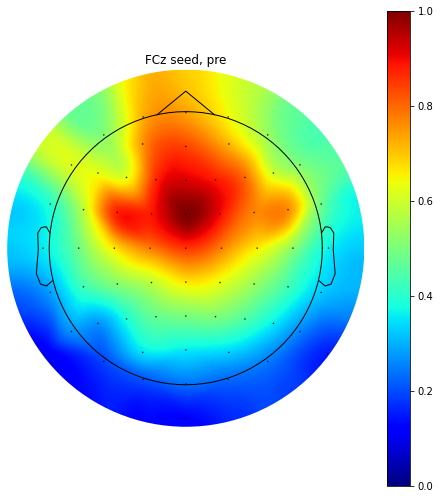

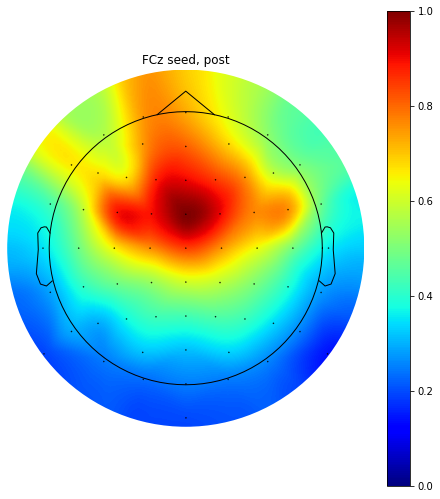

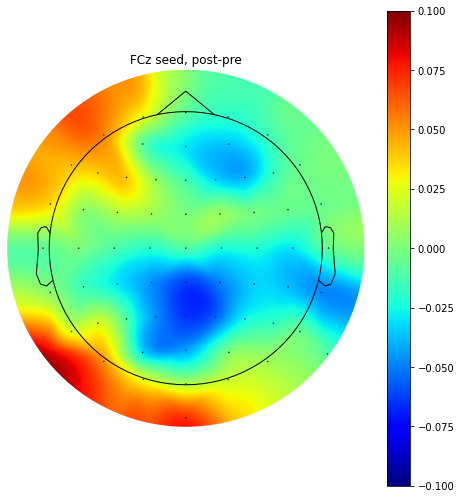

In [169]:
topoPlotIndie(eeg, fcz_seeded_synch[0,:], vlim=clim, contours=0, cmap="jet", title="FCz seed, pre")
topoPlotIndie(eeg, fcz_seeded_synch[1,:], vlim=clim, contours=0, cmap="jet", title="FCz seed, post")
topoPlotIndie(eeg, fcz_seeded_synch[1,:] - fcz_seeded_synch[0,:], vlim=climdiff, contours=0, cmap="jet", title="FCz seed, post-pre")

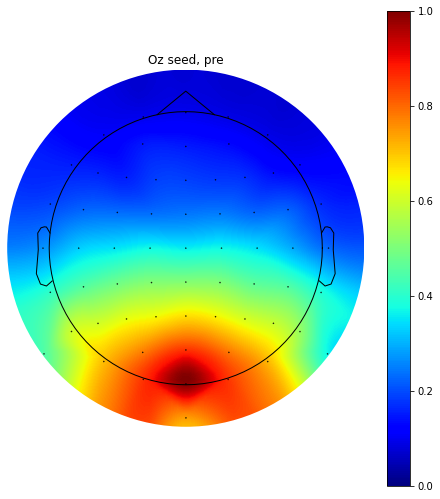

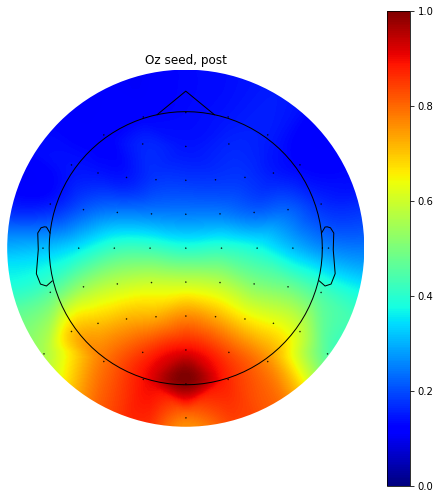

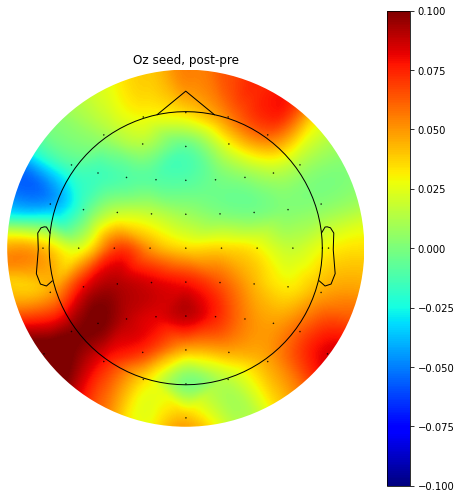

In [170]:
topoPlotIndie(eeg, oz_seeded_synch[0,:], vlim=clim, contours=0, cmap="jet", title="Oz seed, pre")
topoPlotIndie(eeg, oz_seeded_synch[1,:], vlim=clim, contours=0, cmap="jet", title="Oz seed, post")
topoPlotIndie(eeg, oz_seeded_synch[1,:] - oz_seeded_synch[0,:], vlim=climdiff, contours=0, cmap="jet", title="Oz seed, post-pre")